# Grade: /100 pts

# Assignment 06: Feature Selection and Regularization

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

%matplotlib inline

# You're Still a Data Scientist!

Your models from the last assignment really impressed some in the management in your football club. Now that you have learned the art of regularization, your boss thinks you should do equally well with much less data. This will save a lot of money the next time around. This time you only get a data set with 3000 observations.

## Question 1: Preprocessing (5 pts)
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**. If you want to understand why this is, have a look at the Jupyter notebook (`Ridge_And_Dummycoding.ipynb`).  
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0
* visualize all variables of the first 50 observations of the Training data set as an image (see Lab06_followalong). You can also look at it as a data frame. How are the different variables scaled? Which variables have high and which ones have low values?    

To make sure that you get a good start - check the solutions from Assignment 4. And make sure you can apply these steps flexibly and quickly. **You will need it for the midterm!**

Training set size: (2500, 48)


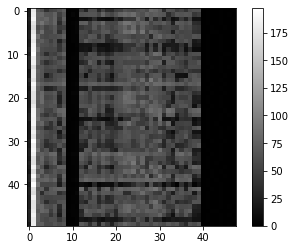

,age,height_cm,weight_kg,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_att_High,work_rate_def_Low,work_rate_def_Medium,work_rate_def_High,preferred_foot_Left,preferred_foot_Right
0,29,186.0,82.0,70,50,56,61,66,74,1,2,3,58,44,65,59,49,56,48,42,58,68,64,74,66,62,59,59,80,73,76,51,70,64,43,52,69,65,63,70,0,1,0,0,1,0,0,1
1,21,194.0,87.0,61,57,53,61,45,54,1,1,2,15,19,15,25,13,16,16,15,19,18,48,42,40,57,33,20,44,39,56,14,25,23,12,26,22,22,15,16,0,1,0,0,1,0,0,1
2,23,175.0,72.0,85,28,55,62,60,68,1,2,2,60,22,54,58,24,59,30,35,57,62,88,83,70,53,75,43,73,79,65,24,58,52,48,55,31,34,60,67,0,1,0,0,0,1,0,1
3,26,185.0,80.0,76,54,67,73,69,78,1,2,3,76,41,60,64,52,75,59,40,73,73,73,78,67,68,63,65,70,87,79,74,67,75,68,68,38,66,66,69,0,1,0,0,1,0,0,1
4,19,182.0,76.0,47,46,51,50,39,47,1,1,2,14,11,13,26,12,14,11,11,22,15,37,41,33,45,43,18,56,28,49,12,18,12,12,25,16,38,12,12,0,1,0,0,1,0,0,1


In [21]:
df = pd.read_csv('footballer_small.csv')

# Drop the aformentioned columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')

# In order to get dummies, convert categorical data to categorical type
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])

# Dummies, without dropping the first category
model_data = pd.get_dummies(model_data, drop_first=False)

y = model_data.overall
X = model_data.drop('overall', axis = 'columns')

# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = 500, 
                                                random_state = 0)
print('Training set size:', Xtrain.shape)

# Show as an image 
plt.imshow(Xtrain.values[0:50,:], cmap='gray')
plt.colorbar()
plt.show()

# show as a data frame 
X.head()

**Both the image and the data frame inspection show that the variables are not evenly scaled. The second column (height) has very large values, whereas reputation, skills, weak_foot and the indicator matrix in the end are very low.**  

## Question 2: Standardization  (10 pts)
When using regularized regression models, the scaling of the different regressors can influence the results dramatically (see lectures). One simple solution is to standardize all features before estimating the model, so that no feature can dominate others due to differences in feature scales. 

a) Use the sklearn class `StandardScaler` to produce a z-scale version of your training data set. Again visualize the the first 50 observations an image. Compare to the plot that you got in Question 1. What do you observe? 

b) Plot a histogram of the second column (height_cm) of the non-standarized and standardized training set. What is the mean and variance of the standardized training set. 

c) Build a model `pipeline` that first standarizes all the features in the training set and then fits a `LinearRegression` model. 


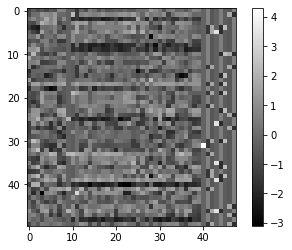

In [22]:
# a) Standarize and plot image 
StdScl = StandardScaler() # Make Scaler object 
std_Xtrain = StdScl.fit_transform(Xtrain) # Scale the design matrix
# Show as an image 
plt.imshow(std_Xtrain[0:50,:], cmap='gray')
plt.colorbar()
plt.show()

All features are now centered around zero and evenly scaled 

[Text(0, 0.5, 'frequency'),
 Text(0.5, 0, 'stamina'),
 Text(0.5, 1.0, 'After Standardization')]

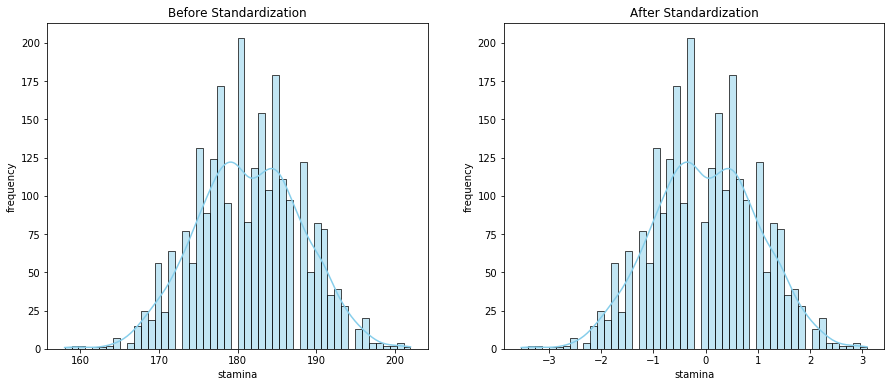

In [23]:
# b) Plot historgram 
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax = sns.histplot(Xtrain.values[:,1],
                 bins=50,
                 kde=True,
                 color='skyblue',
                 cbar_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='stamina', ylabel='frequency', title="Before Standardization")
plt.subplot(1, 2, 2)

ax = sns.histplot(std_Xtrain[:,1],
                 bins=50,
                 kde=True,
                 color='skyblue',
                 cbar_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='stamina', ylabel='frequency', title="After Standardization")

The distribution is unchanged - but the mean has been shifted towards zero and the variance is now 1. 

In [24]:
# c: Build pipeline
model_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', sk.linear_model.LinearRegression())
])

## Question 3: Comparing different complex features (10 pts)
In this task, we will first consider a model that includes all the variables in the data AND all quadratic terms (i.e. each features to the power of two, and the products (interactions) between all possible pairs of features. 

a) Generate a design matrix for the model. You can use sklearn's `PolynomialFeatures` to do the job. Because sklearn's linear models have the option to fit the intercept, internally, set the `include_bias` option to `False`. 
* How many linear terms are in each of the new feature set?
* How many squared terms are in each of the new feature set?
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 

b) Now generate 3 more models / design matrices. Again it should include all quadratic terms and 2-way interactions - but each model should drop one of the features
* Second Model: Drop `standing_tackle`
* Third Model: Drop `composure`
* Fourth model: Drop `marking`

Hint: For these models, create the design matrix without the aforementioned features and then apply polynomial expansion to the remaing features. 


In [25]:
# a) Make the new expanded design matrix 

poly = sk.preprocessing.PolynomialFeatures(2, include_bias=False)
X_new_train = poly.fit_transform(Xtrain)
X_new_train.shape

(2500, 1224)

Here are 48 columns in our original design matrix. 

Setting `degree=2` and `interactions_only=False` computes $x_i\cdot x_j$ for all $i,j=1, \cdots, 48$ and then adds this to our original design matrix. Note that when $i\neq j$, the ordering of the terms does not matter. This is a total of

* 48 linear linear terms
* 48 squared terms 
* 48x47/2  interaction terms (If you are interested in knowing how I computed this, read the wikipedia page for "Triangular Number").

Total of 1224 features

In [26]:
# Make design matrices without one of the features
Xwithout_standing = Xtrain.drop(['standing_tackle'], axis='columns')
Xwithout_standing = poly.fit_transform(Xwithout_standing)

Xwithout_composure = Xtrain.drop(['composure'], axis='columns')
Xwithout_composure = poly.fit_transform(Xwithout_composure)

Xwithout_marking= Xtrain.drop(['marking'], axis='columns')
Xwithout_marking = poly.fit_transform(Xwithout_marking)

## Question 4: Evaluating the backward feature search (10 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the models in question 3. Use 10-fold cross validation to report the validation error on the models using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. For this first step in the backwards search, which feature would you drop? 

In [27]:
cv_score=cross_val_score(model_pipeline, X_new_train, ytrain, cv=10, scoring='neg_mean_squared_error')
print('base model', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_standing, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without standing tackle', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_composure, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without composure', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_marking, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without marking', -cv_score.mean())

base model 2.974946308807408
model without standing tackle 2.747797303780692
model without composure 2.7955817375187033
model without marking 2.694920751659353


The base model that includes all the features is the worst performing model. The best performing model out of the four models is the model that excludes the marking feature and its corresponding quadratic and interacting feature. This means that this feature has contributed to the degradation of the quality of the model. In a backward search, I would therefore drop that feature and make this model the new base model.  

## Question 5: Applying Ridge Regression (10 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The ridge parameter ($\lambda$ or `alpha` in sklearn) should be set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [28]:
pip = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=0.5, fit_intercept=True))
])

cv_scores = cross_val_score(pip,
                           X_new_train,
                           ytrain,
                           cv=10,
                           scoring='neg_mean_squared_error')
meancv=-cv_scores.mean()
print(meancv)

1.714677002041243


## Question 6: Tune the Ridge coefficient for the 2nd-order model (15 pts)
Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. 

For each setting of lambda, calculate the training error when fitting the regularized model to the entire trainign data set, and the prediction error by studying the performance on the left-out part using 10-fold cross-validation. (*Note this calculation can take a bit, be patient*)

Plot the mean squared training error and mean squared validation error as a function of $\log(\lambda)$. 

Note: Although you can ultimately use `GridSearchCV` from sklearn, in this task you need to program a for-loop interating over all the levels of $\lambda$.  

### Questions: 

What is the best regularization parameter? 

Why does the validation error increase as $\lambda \rightarrow 0$, while the training error decreases from the optimal value?  Why does both the training and the validation error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off and model complexity.


Text(0.5, 0, '$\\log(\\lambda)$')

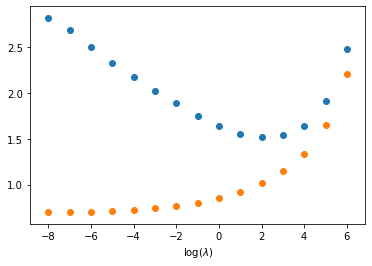

In [29]:
params = np.exp(np.linspace(-8,6,15))
mse_cv = np.zeros(params.shape)
mse_train = np.zeros(params.shape)

for i,lam in enumerate(params):
    pip = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=lam, fit_intercept=True))])
    cv_scores = cross_val_score(pip, X_new_train, ytrain,cv=10,scoring = 'neg_mean_squared_error')
    mse_cv[i]=-cv_scores.mean()
    pip.fit(X_new_train,ytrain) 
    Yp = pip.predict(X_new_train)
    mse_train[i]= np.mean((ytrain-Yp)**2) 

plt.scatter( np.linspace(-8, 6,15),mse_cv)
plt.scatter( np.linspace(-8, 6,15),mse_train)
plt.xlabel(r'$\log(\lambda)$')

### Answer: 
The best value is $\lambda = exp(2)$. 

As $\lambda \rightarrow 0$, the model is becoming more complex. The model prediction is less biased (lower training error), but also more variable, which causes the validation error to increase. 

As $\lambda \rightarrow \infty$, the model is becoming less complex. The variability decreases, but the bias increases, causing both the training and validation error to increase. 

## Question 7: Test error  (10 pts)
Now fit the model using ridge regression, using the lambda-value that you determined works best (in terms of crossvalidated mse) from Question 6. Fit the model on the whole training set. 

Report the mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem (remember assignment 5). 

In [30]:
X_new_test = poly.fit_transform(Xtest)
pip = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=np.exp(2), fit_intercept=True))])
pip.fit(X_new_train,ytrain)
ypred = pip.predict(X_new_test)
sqerr = (ytest-ypred)**2 
test_error = sqerr.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])

print("Mean squared error: ",test_error)
print("95% CI: ",test_ci)


Mean squared error:  1.7057441746268402
95% CI:  [1.38183746 2.02965089]


## Question 8: Lasso Regression (10 pts)
That's great! You can achieve a really good prediction accuracy with much less data than in Week 5. Impressive! 

Now the problem is that the model is really hard to interpret and explain to clients- the importance of each feature is not easily apparent. So let's build a simpler model, which is only based on the first nine features:
* age
* height_cm
* weight_kg 
* pac: ???  
* sho: shooting 
* pas: passing 
* dri: dribble 
* def: defense
* phy: Physiological VO2 max

Build a design matrix using only these nine features. Standardize the design matrix using the standard scalar. 
Then use `sklearn.linear_model.lasso_path` to create a plot of the regression coefficients against the log-regularization parameter (see `Lab06_followalong`). Note that it is standard practice to plot on the x-axis the negative log-lambda values, such that the high regularization (and hence the simpler models) are on the left. 

Which of the 9 variables drops out of the predicitive model first? Which one is retained for the longest time? 

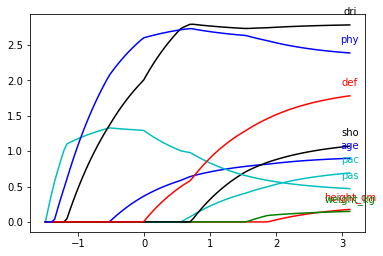

In [34]:
# Make a new, reduced design matrix 
Xt = Xtrain.iloc[:,0:9]
Xts = StdScl.fit_transform(Xt)

# Create a lasso path 
eps = 0.01
lambda_lasso, coefs_lasso, _ = sk.linear_model.lasso_path(Xts, ytrain, eps=eps,
                                                          n_alphas=100, alphas= None, fit_intercept=True)

# Plot the lasso path
colors = ['b', 'r', 'g', 'c', 'k','c','k','r','b']
neg_log_lambda = -np.log(lambda_lasso)
for i in range(9):
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,], c=colors[i])
    label = Xt.columns[i]
    plt.annotate(label, # this is the text
                 (neg_log_lambda[-1],coefs_lasso[i,-1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color = colors[i]) # horizontal alignment can be left, right or center
                

**Answer: Weight_kg (shortly followed by height_cm) is the first variable to be removed from the predictive model. 
Pas (passing ability) is the variable that is retained for the longest time in the model. This is even though in the full model it is not the variable that has the highest weight.**

## Question 9: Tuning the lasso coefficient (10pts) 
We now want to find a model that is both simple (explainable), but at the same time yields still relatively decent predictions. To assess this, vary the regularization constant of the lasso model between exp(2) end exp(-3.5). That is, vary negative log lambda between -2 and 3.5 in even steps. 
Plot the crossvalidation error (mean squared error) against negative-log-lambda of the model. 

Hint: You can either program a for-loop as in Question 6, or use the function `GridSearchCV`. 

What is the simplest model that still gives you a expected validation error of below 15? 
If you wanted the best validation error, what $\lambda$ would you need to use?

Text(0, 0.5, 'Validation error')

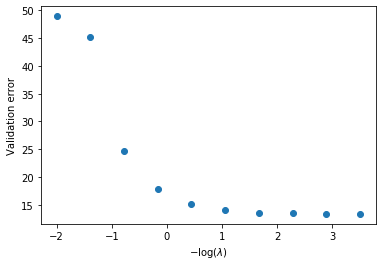

In [32]:
pip = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Lasso(alpha=lam, fit_intercept=True))])

neg_log_lambda = np.linspace(-2,3.5,10)
params = {'reg__alpha': np.exp(-neg_log_lambda)}

gscv = GridSearchCV(pip, param_grid=params, cv=10, scoring = 'neg_mean_squared_error', refit=True)
gscv.fit(Xts, ytrain)
results = pd.DataFrame(gscv.cv_results_)

plt.scatter( neg_log_lambda, -results.mean_test_score)
plt.xlabel(r'$-\log(\lambda)$')
plt.ylabel('Validation error')


**Answer: The model with negative log lambda of 1.05 is the simplest (most regularized model that still has a validation error of below 15. The best lambda is the smallest  value ($exp(-3.5)$).**

## Question  10: Lasso vs. Ridge (10pts)
In this quesiton, we will compare Ridge regression and Lasso solutions on the model defined in Question 8. Make sure you are using a standardized design matrix for this task. 

Fit the model using Ridge (L2- regularization, $\lambda = exp(-3)$) and Lasso (L1-regularization, $\lambda = exp(-0.5)$. Then print out the regression coefficients for each of the nine features in the design matrix. 

Based on the coefficients, which one is the most important feature in the Ridge vs. Lasso solution? How many features are contributing to the prediction for each solution? How can this difference be explained? 


In [33]:
myRidge = Ridge(alpha=np.exp(-3),fit_intercept=True)
myLasso = Lasso(alpha=np.exp(-0.5),fit_intercept=True)
myRidge.fit(Xts,ytrain)
myLasso.fit(Xts,ytrain)
print(f'Ridge coefficients {myRidge.coef_.round(2)}')
print(f'Lasso Coefficients {myLasso.coef_.round(2)}')

Ridge coefficients [0.93 0.25 0.17 0.77 1.16 0.42 2.8  1.91 2.32]
Lasso Coefficients [0.57 0.   0.   0.   0.   1.03 2.68 0.46 2.71]



### Answer
In the grand scheme of things, both lasso and ridge regression shrink the less important features' coefficients to enhance the performance of the linear regression model. The key difference between the two techniques is that lasso regression intrinsically applies feature selection by shrinking feature coefficients to zero which removes some features. The results show that marking feature is the less important feature out of the ones considered, followed by composure feature and lastly the standing tackle feature. With the increase of the $\lambda$ parameter, the coefficient of the marking feature shrinks to 0, rendering it ineffective in the prediction of the player's overall, then the coefficient of the composure feature shrinks to 0, which leaves the model with a single feature to predict the overall rating. 